## Evaluation

In [30]:
import torch
import numpy as np
import random
from models.architectures import srgan, srflow
import PIL
import os
import torchvision
from torchvision import transforms
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np

# Set a seed for reproducibility
np.random.seed(42)

# Dataset loading
from data import dataloading
from data.era5_temp_dataset import InverseMinMaxScaler

from os.path import exists, join
import matplotlib.pyplot as plt
from matplotlib import transforms
import timeit
import pdb
import argparse
import seaborn as sns

from utils.metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
print('GPUs avail:', torch.cuda.device_count())

# Parse Settings
parser = argparse.ArgumentParser()

# train configs
parser.add_argument("--model", type=str, default="srflow",
                    help="Model you want to train.")
parser.add_argument("--modeltype", type=str, default="srflow",
                    help="Specify modeltype you would like to train [srflow, cdiff, srgan].")
parser.add_argument("--model_path", type=str, default="runs/",
                    help="Directory where models are saved.")
parser.add_argument("--modelname", type=str, default=None,
                    help="Sepcify modelname to be tested.")
parser.add_argument("--epochs", type=int, default=10000,
                    help="number of epochs")
parser.add_argument("--max_steps", type=int, default=2000000,
                    help="For training on a large dataset.")
parser.add_argument("--log_interval", type=int, default=100,
                    help="Interval in which results should be logged.")

# runtime configs
parser.add_argument("--visual", action="store_true",
                    help="Visualizing the samples at test time.")
parser.add_argument("--noscaletest", action="store_true",
                    help="Disable scale in coupling layers only at test time.")
parser.add_argument("--noscale", action="store_true",
                    help="Disable scale in coupling layers.")
parser.add_argument("--testmode", action="store_true",
                    help="Model run on test set.")
parser.add_argument("--train", action="store_true",
                    help="If model should be trained.")
parser.add_argument("--resume_training", action="store_true",
                    help="If training should be resumed.")
parser.add_argument("--constraint", type=str, default='scaddDS',
                    help="Physical Constraint to be applied during training.")                   

# hyperparameters
parser.add_argument("--nbits", type=int, default=8,
                    help="Images converted to n-bit representations.")
parser.add_argument("--s", type=int, default=16, help="Upscaling factor.")
parser.add_argument("--bsz", type=int, default=16, help="batch size")
parser.add_argument("--lr", type=float, default=0.0002, help="learning rate")
parser.add_argument("--filter_size", type=int, default=512, help="filter size NN in Affine Coupling Layer")
parser.add_argument("--L", type=int, default=3, help="# of levels")
parser.add_argument("--K", type=int, default=2,
                    help="# of flow steps, i.e. model depth")
parser.add_argument("--nb", type=int, default=16,
                    help="# of residual-in-residual blocks LR network.")
parser.add_argument("--condch", type=int, default=128//8,
                    help="# of residual-in-residual blocks in LR network.")

# data
parser.add_argument("--datadir", type=str, default="/home/christina/Documents/clim-var-ds-cnf-own/data/",
                    help="Dataset to train the model on.")
parser.add_argument("--trainset", type=str, default="era5-TCW", help='[era5-TCW, era5-T2M]')
parser.add_argument("--testset", type=str, default="era5-TCW", help="Specify test dataset")

args = parser.parse_args('')
config = vars(args)

GPUs avail: 1


In [32]:
if torch.cuda.is_available():
    args.device = torch.device("cuda")
    args.num_gpus = torch.cuda.device_count()
    args.parallel = False

else:
    args.device = "cpu"

In [33]:
# use min-max due to non-gaussian distribution of data and outlier handling
def min_max_scaler(x, min_val=0, max_val=124):
    if min_val is None:
        min_val = x.min()
    if max_val is None:
        max_val = x.max()
    scaled_x = (x - min_val) / (max_val - min_val)
    return scaled_x, min_val, max_val

def inv_min_max_scaler(scaled_x, min_val=0, max_val=124):
    x = scaled_x * (max_val - min_val) + min_val
    return x

In [34]:
import os
import torch

def load_model(exp_dir, model, mpath):
    """
    Load a model from the specified directory and checkpoint file.
    
    Parameters:
    exp_dir (str): The experiment directory path.
    model (torch.nn.Module): The model instance to load the state dictionary into.
    mpath (str): The path to the model checkpoint file.
    
    Returns:
    torch.nn.Module: The loaded model with the state dictionary.
    
    Raises:
    FileNotFoundError: If the model file does not exist at the specified path.
    """
    try:
        # Check if the file exists
        if not os.path.exists(mpath):
            raise FileNotFoundError(f"Model file not found at {mpath}")
        
        # Load the checkpoint
        ckpt = torch.load(mpath)
        
        # Load the state dictionary into the model
        model.load_state_dict(ckpt['model_state_dict'])
        
        print("Model loaded successfully.")
        return model

    except FileNotFoundError as e:
        print(e)
        return None

### Metric Evaluation
Evaluations: 
- CNF unconstrained vs. constrained
- CNF vs. GAN vs. CDiff
- Residual Error Plots for ???
- Metrics for 2x,4x,8x,16x with and without constraints

In [35]:
import os
import json
import torch
import torchvision.utils as vutils
import sys
sys.path.append("../../")
from utils import metrics

def save_snapshot(tensor, path):
    # Function to save tensor as image in Viridis color scheme
    plt.figure()
    plt.imshow(tensor[0,...].cpu().numpy().squeeze(), cmap='viridis')
    plt.axis('off')
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

def save_grid_images(tensor_batch, save_path, nrow=3, title=None):
    
    # Create a grid of images
    grid_img = vutils.make_grid(tensor_batch[0:9], nrow=nrow, normalize=True, scale_each=True)

    # Convert the grid to numpy and plot
    np_grid = grid_img.cpu().numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(np_grid[:, :, 0], cmap='viridis')  # Use Viridis colormap for grayscale images
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)

    # Save the grid image
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
def metric_eval_flow(dataloader, model, exp_name, args):
    metric_dict = {
        'rmse0': [], 'mse0': [], 'mae0': [],
        'rmse05': [], 'mse05': [], 'mae05': [],
        'rmse08': [], 'mse08': [], 'mae08': [],
        'rmse1': [], 'mse1': [], 'mae1': [],
        'crps0': [], 'crps05': [],'crps08': [],'crps1': [],
    }

    # Create directories
    results_dir = os.path.join(exp_name, 'experiment_results')
    os.makedirs(results_dir, exist_ok=True)
    
    snapshots_dir = os.path.join(results_dir, 'snapshots')
    os.makedirs(snapshots_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        for batch_idx, item in enumerate(dataloader):
            
            y = item[0].to(args.device)
            x = item[1].to(args.device)

            y_unorm = item[2].to(args.device)
            x_unorm = item[3].to(args.device)

            z, _ = model.forward(x_hr=y, xlr=x)

            # Evaluate for different temperatures
            mu0, _, _ = model(xlr=x, reverse=True, eps=0)
            mu05, _, _ = model(xlr=x, reverse=True, eps=0.5)
            mu08, _, _ = model(xlr=x, reverse=True, eps=0.8)
            mu1, _, _ = model(xlr=x, reverse=True, eps=1.0)

            # Compute and store MSE for each temperature
            mse0 = metrics.MSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            mse05 = metrics.MSE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            mse08 = metrics.MSE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            mse1 = metrics.MSE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()
            
            metric_dict['mse0'].append(mse0)
            metric_dict['mse05'].append(mse05)
            metric_dict['mse08'].append(mse08)
            metric_dict['mse1'].append(mse1)

            # Compute and store MAE for each temperature
            mae0 = metrics.MAE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            mae05 = metrics.MAE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            mae08 = metrics.MAE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            mae1 = metrics.MAE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()

            metric_dict['mae0'].append(mae0)
            metric_dict['mae05'].append(mae05)
            metric_dict['mae08'].append(mae08)
            metric_dict['mae1'].append(mae1)

            # Compute and store RMSE for each temperature
            rmse0 = metrics.RMSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            rmse05 = metrics.RMSE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            rmse08 = metrics.RMSE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            rmse1 = metrics.RMSE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()

            metric_dict['rmse0'].append(rmse0)
            metric_dict['rmse05'].append(rmse05)
            metric_dict['rmse08'].append(rmse08)
            metric_dict['rmse1'].append(rmse1)

             # Calculate CRPS for ensemble
            metric_dict['crps0'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu0)))
            metric_dict['crps05'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu05)))
            metric_dict['crps08'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu08)))
            metric_dict['crps1'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu1)))
            
            # Save grid of images for visualization (adjust as needed)
            if batch_idx == 0:  # Save only for the first batch for simplicity
                # Save snapshots
                save_grid_images(y_unorm, os.path.join(snapshots_dir, f'ground_truth_{batch_idx}.png'))
                save_grid_images(mu0, os.path.join(snapshots_dir, f'prediction_mu0_{batch_idx}.png'))
                save_grid_images(mu05, os.path.join(snapshots_dir, f'prediction_mu05_{batch_idx}.png'))
                save_grid_images(mu08, os.path.join(snapshots_dir, f'prediction_mu08_{batch_idx}.png'))
                save_grid_images(mu1, os.path.join(snapshots_dir, f'prediction_mu1_{batch_idx}.png'))
                save_grid_images(x_unorm, os.path.join(snapshots_dir, f'low_res_{batch_idx}.png'))
                
            print(f'Current RMSE - mu0: {rmse0}, mu05: {rmse05}, mu08: {rmse08}, mu1: {rmse1}')
            print(f'Current MAE - mu0: {mae0}, mu05: {mae05}, mu08: {mae08}, mu1: {mae1}')
            # print(f'Current CRPS - mu0:{crps0}, mu05: {crps05}, mu08: {crps08}, m1: {crps1}')

            # if batch_idx == 200:
            #     break
        # Create a string representation of the metric_dict
        mean_dict = {}
        for key, value in metric_dict.items():
            if len(value) > 0:
                mean_dict[key] = np.mean(value)   
        print(mean_dict)

    # Create a string representation of the metric_dict
    mean_dict = {}
    for key, value in metric_dict.items():
        if len(value) > 0:
            mean_dict[key] = np.mean(value)   
            
    metric_str = "\n".join([f"{key}: {value}" for key, value in mean_dict.items()])

    # Save metric_dict to a text file
    with open(os.path.join(results_dir, 'metrics.txt'), 'w') as f:
        json.dump(metric_str, f, indent=4)
        
    print(mean_dict)
    return mean_dict

# Experiments: Comparing across upsampling factors


In [36]:
# load model
print('Num of avail GPUs:', torch.cuda.device_count())

Num of avail GPUs: 1


In [37]:
import gc
gc.collect()

31251

### Conditional Flow Model

In [38]:
args.s = 2
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf2x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 2, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_09_2x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_09_2x/model_checkpoints/model_epoch_8_step_21500.tar'
# Load the model
cnf2x = load_model(exp_dir, cnf2x, cnf_path).to(args.device)
metric_eval_flow(test_loader, cnf2x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.
Current RMSE - mu0: 0.17884618043899536, mu05: 0.21108201146125793, mu08: 0.24816080927848816, mu1: 0.2844439148902893
Current MAE - mu0: 0.09370577335357666, mu05: 0.11698420345783234, mu08: 0.1434328705072403, mu1: 0.16564702987670898
Current RMSE - mu0: 0.236566960811615, mu05: 0.27160874009132385, mu08: 0.32130980491638184, mu1: 0.3639145493507385
Current MAE - mu0: 0.12648537755012512, mu05: 0.15218499302864075, mu08: 0.18451304733753204, mu1: 0.21058383584022522
Current RMSE - mu0: 0.18981394171714783, mu05: 0.22772225737571716, mu08: 0.280303955078125, mu1: 0.3131583333015442
Current MAE - mu0: 0.1017846092581749, mu05: 0.12810713052749634, mu08: 0.1595415621995926, mu1: 0.18201452493667603
Current RMSE - mu0: 0.2651246190071106, mu05: 0.3149281144142151, mu08: 0.3812113404273987, mu1: 0.42571163177490234
Current MAE - mu0: 0.14871303737163544, mu05: 0.1818871647119522, mu08: 0.2222333699464798, mu1: 0.2497004270553589
Current RMSE

KeyboardInterrupt: 

In [23]:
gc.collect()

147

In [13]:
args.s = 4
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf4x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 4, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_13_4x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_13_4x/model_checkpoints/model_epoch_10_step_26250.tar'
# Load the model
cnf4x = load_model(exp_dir, cnf4x, cnf_path).to(args.device)
metric_eval_flow(test_loader, cnf4x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.
Current RMSE - mu0: 0.48445749282836914, mu05: 0.5497838258743286, mu08: 0.6331164836883545, mu1: 0.7063823938369751
Current MAE - mu0: 0.2833460867404938, mu05: 0.3329157829284668, mu08: 0.39429035782814026, mu1: 0.4425612688064575
Current RMSE - mu0: 0.660796046257019, mu05: 0.7459709644317627, mu08: 0.8538327217102051, mu1: 0.9509994983673096
Current MAE - mu0: 0.38327863812446594, mu05: 0.44709357619285583, mu08: 0.5285980105400085, mu1: 0.5908297300338745
Current RMSE - mu0: 0.5357289910316467, mu05: 0.602929949760437, mu08: 0.6921342015266418, mu1: 0.7740520238876343
Current MAE - mu0: 0.3102187514305115, mu05: 0.36552053689956665, mu08: 0.43306758999824524, mu1: 0.4888858497142792
Current RMSE - mu0: 0.7021902203559875, mu05: 0.799588680267334, mu08: 0.9147934317588806, mu1: 1.0608819723129272
Current MAE - mu0: 0.4194105565547943, mu05: 0.48660188913345337, mu08: 0.5703456401824951, mu1: 0.6496960520744324
Current RMSE - mu0: 0.53

{'rmse0': [array(0.4844575, dtype=float32),
  array(0.66079605, dtype=float32),
  array(0.535729, dtype=float32),
  array(0.7021902, dtype=float32),
  array(0.5345534, dtype=float32),
  array(0.53129745, dtype=float32),
  array(0.58081996, dtype=float32),
  array(0.54456306, dtype=float32),
  array(0.6393016, dtype=float32),
  array(0.5850318, dtype=float32),
  array(0.45357272, dtype=float32),
  array(0.6907858, dtype=float32),
  array(0.5726379, dtype=float32),
  array(0.6146871, dtype=float32),
  array(0.46337536, dtype=float32),
  array(0.51045215, dtype=float32),
  array(0.6622318, dtype=float32),
  array(0.5587851, dtype=float32),
  array(0.49564293, dtype=float32),
  array(0.5329642, dtype=float32),
  array(0.5232176, dtype=float32),
  array(0.37734157, dtype=float32),
  array(0.5012482, dtype=float32),
  array(0.45465568, dtype=float32),
  array(0.5130371, dtype=float32),
  array(0.49372, dtype=float32),
  array(0.6436701, dtype=float32),
  array(0.50554013, dtype=float32),
  a

In [14]:
gc.collect()

9867

In [29]:
args.s = 8
args.device = 'cuda'
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf8x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, args.s, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_12_8x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_12_8x/model_checkpoints/model_epoch_4_step_11500.tar'
# Load the model
cnf8x = load_model(exp_dir, cnf8x, cnf_path).to(args.device)
metric_eval_flow(test_loader, cnf8x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.
Current RMSE - mu0: 1.158689022064209, mu05: 1.2857942581176758, mu08: 1.484177589416504, mu1: 1.772631287574768
Current MAE - mu0: 0.7625826597213745, mu05: 0.8697299957275391, mu08: 1.017438292503357, mu1: 1.1900774240493774
Current RMSE - mu0: 1.5189921855926514, mu05: 1.6821174621582031, mu08: 1.9912199974060059, mu1: 2.3189568519592285
Current MAE - mu0: 1.002374529838562, mu05: 1.1381947994232178, mu08: 1.3589637279510498, mu1: 1.5762441158294678
Current RMSE - mu0: 1.2048765420913696, mu05: 1.3723876476287842, mu08: 1.6237421035766602, mu1: 1.8735389709472656
Current MAE - mu0: 0.8028008341789246, mu05: 0.9358267784118652, mu08: 1.1196489334106445, mu1: 1.2852938175201416
Current RMSE - mu0: 1.5562090873718262, mu05: 1.7300748825073242, mu08: 2.122504949569702, mu1: 2.446990728378296
Current MAE - mu0: 1.022737979888916, mu05: 1.1677345037460327, mu08: 1.4281980991363525, mu1: 1.6515039205551147
Current RMSE - mu0: 1.27882695198059

{'rmse0': 1.2616284,
 'mse0': 2.1301696,
 'mae0': 0.8331674,
 'rmse05': 1.4048977,
 'mse05': 2.6654382,
 'mae05': 0.9477329,
 'rmse08': 1.6555965,
 'mse08': 3.8184469,
 'mae08': 1.1252381,
 'rmse1': 20708719000.0,
 'mse1': 4.282582e+24,
 'mae1': 578160800.0,
 'crps0': 0.51439893,
 'crps05': 0.60502124,
 'crps08': 0.71387655,
 'crps1': 317171460.0}

In [16]:
gc.collect()

9859

In [35]:
args.s = 16
args.device = 'cuda'
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf16x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 16, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_12_16x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_12_16x/model_checkpoints/model_epoch_5_step_13750.tar'
# Load the model
cnf16x = load_model(exp_dir, cnf16x, cnf_path).to(args.device)
metric_eval_flow(test_loader, cnf16x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.
Current RMSE - mu0: 2.451587200164795, mu05: 2.5492963790893555, mu08: 2.830251693725586, mu1: 3.1891274452209473
Current MAE - mu0: 1.7469589710235596, mu05: 1.8241560459136963, mu08: 2.053370475769043, mu1: 2.356588840484619
Current RMSE - mu0: 3.292207956314087, mu05: 3.365593433380127, mu08: 3.7799482345581055, mu1: 4.139266014099121
Current MAE - mu0: 2.327131748199463, mu05: 2.4040064811706543, mu08: 2.759612560272217, mu1: 3.040996551513672
Current RMSE - mu0: 2.564749240875244, mu05: 2.731642246246338, mu08: 3.0603742599487305, mu1: 3.41984224319458
Current MAE - mu0: 1.8245995044708252, mu05: 1.9635785818099976, mu08: 2.22550630569458, mu1: 2.510685920715332
Current RMSE - mu0: 3.235889434814453, mu05: 3.313453197479248, mu08: 3.7406039237976074, mu1: 4.077687740325928
Current MAE - mu0: 2.294898509979248, mu05: 2.3696184158325195, mu08: 2.70449161529541, mu1: 2.984051465988159
Current RMSE - mu0: 2.846376895904541, mu05: 2.97644

{'rmse0': 2.751227,
 'mse0': 9.48738,
 'mae0': 1.9537641,
 'rmse05': 2.8600616,
 'mse05': 10.175083,
 'mae05': 2.0541925,
 'rmse08': 3.1955893,
 'mse08': 12.725655,
 'mae08': 2.3337612,
 'rmse1': 3.5692577,
 'mse1': 18.377237,
 'mae1': 2.6122434,
 'crps0': 0.8439635,
 'crps05': 1.0338562,
 'crps08': 1.2153039,
 'crps1': 1.3690166}

In [ ]:
gc.collect()

### Conditional GAN

In [27]:
import os
import json
import torch
import torchvision.utils as vutils
import sys
sys.path.append("../../")
from utils import metrics

def save_snapshot(tensor, path):
    # Function to save tensor as image in Viridis color scheme
    plt.figure()
    plt.imshow(tensor[0,...].cpu().numpy().squeeze(), cmap='viridis')
    plt.axis('off')
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

def save_grid_images(tensor_batch, save_path, nrow=3, title=None):
    
    # Create a grid of images
    grid_img = vutils.make_grid(tensor_batch[0:9], nrow=nrow, normalize=True, scale_each=True)

    # Convert the grid to numpy and plot
    np_grid = grid_img.cpu().numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(np_grid[:, :, 0], cmap='viridis')  # Use Viridis colormap for grayscale images
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)

    # Save the grid image
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
def metric_eval_gan(dataloader, model, exp_name, args):
    metric_dict = {
        'rmse0': [], 'mse0': [], 'mae0': [],
        'rmse05': [], 'mse05': [], 'mae05': [],
        'rmse08': [], 'mse08': [], 'mae08': [],
        'rmse1': [], 'mse1': [], 'mae1': [],
        'crps0': [], 'crps05': [],'crps08': [],'crps1': [],
    }

    # Create directories
    results_dir = os.path.join(exp_name, 'experiment_results')
    os.makedirs(results_dir, exist_ok=True)
    
    snapshots_dir = os.path.join(results_dir, 'snapshots')
    os.makedirs(snapshots_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        for batch_idx, item in enumerate(dataloader):
            
            y = item[0].to(args.device)
            x = item[1].to(args.device)

            y_unorm = item[2].to(args.device)
            x_unorm = item[3].to(args.device)

            # Evaluate for different temperatures
            mu0 = model(x, eps=0)
            mu05 = model(x, eps=0.5)
            mu08 = model(x, eps=0.8)
            mu1 = model(x, eps=1.0)

            # Compute and store MSE for each temperature
            mse0 = metrics.MSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            mse05 = metrics.MSE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            mse08 = metrics.MSE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            mse1 = metrics.MSE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()
            
            metric_dict['mse0'].append(mse0)
            metric_dict['mse05'].append(mse05)
            metric_dict['mse08'].append(mse08)
            metric_dict['mse1'].append(mse1)

            # Compute and store MAE for each temperature
            mae0 = metrics.MAE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            mae05 = metrics.MAE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            mae08 = metrics.MAE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            mae1 = metrics.MAE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()

            metric_dict['mae0'].append(mae0)
            metric_dict['mae05'].append(mae05)
            metric_dict['mae08'].append(mae08)
            metric_dict['mae1'].append(mae1)

            # Compute and store RMSE for each temperature
            rmse0 = metrics.RMSE(inv_min_max_scaler(mu0), y_unorm).detach().cpu().numpy()
            rmse05 = metrics.RMSE(inv_min_max_scaler(mu05), y_unorm).detach().cpu().numpy()
            rmse08 = metrics.RMSE(inv_min_max_scaler(mu08), y_unorm).detach().cpu().numpy()
            rmse1 = metrics.RMSE(inv_min_max_scaler(mu1), y_unorm).detach().cpu().numpy()

            metric_dict['rmse0'].append(rmse0)
            metric_dict['rmse05'].append(rmse05)
            metric_dict['rmse08'].append(rmse08)
            metric_dict['rmse1'].append(rmse1)

             # Calculate CRPS for ensemble
            metric_dict['crps0'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu0)))
            metric_dict['crps05'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu05)))
            metric_dict['crps08'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu08)))
            metric_dict['crps1'].append(crps_ensemble(y_unorm, inv_min_max_scaler(mu1)))
            
            # Save grid of images for visualization (adjust as needed)
            if batch_idx == 0:  # Save only for the first batch for simplicity
                # Save snapshots
                save_grid_images(y_unorm, os.path.join(snapshots_dir, f'ground_truth_{batch_idx}.png'))
                save_grid_images(mu0, os.path.join(snapshots_dir, f'prediction_mu0_{batch_idx}.png'))
                save_grid_images(mu05, os.path.join(snapshots_dir, f'prediction_mu05_{batch_idx}.png'))
                save_grid_images(mu08, os.path.join(snapshots_dir, f'prediction_mu08_{batch_idx}.png'))
                save_grid_images(mu1, os.path.join(snapshots_dir, f'prediction_mu1_{batch_idx}.png'))
                save_grid_images(x_unorm, os.path.join(snapshots_dir, f'low_res_{batch_idx}.png'))
                
            print(f'Current RMSE - mu0: {rmse0}, mu05: {rmse05}, mu08: {rmse08}, mu1: {rmse1}')
            print(f'Current MAE - mu0: {mae0}, mu05: {mae05}, mu08: {mae08}, mu1: {mae1}')
            # print(f'Current CRPS - mu0:{crps0}, mu05: {crps05}, mu08: {crps08}, m1: {crps1}')

            # if batch_idx == 200:
            #     break

    # Create a string representation of the metric_dict
    mean_dict = {}
    for key, value in metric_dict.items():
        if len(value) > 0:
            mean_dict[key] = np.mean(value)   
            
    metric_str = "\n".join([f"{key}: {value}" for key, value in mean_dict.items()])

    # Save metric_dict to a text file
    with open(os.path.join(results_dir, 'metrics.txt'), 'w') as f:
        json.dump(metric_str, f, indent=4)
        
    print(mean_dict)
    return mean_dict

In [18]:
args.s = 2
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan2x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_28_2x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_28_2x/model_checkpoints/generator_epoch_13_step_34000.tar'
# Load the model
srgan2x = load_model(exp_dir, srgan2x, gan_path).to(args.device)
metric_eval_gan(test_loader, srgan2x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Current RMSE - mu0: 0.44392892718315125, mu05: 0.45011842250823975, mu08: 0.45962876081466675, mu1: 0.4776063561439514
Current MAE - mu0: 0.23985347151756287, mu05: 0.24804989993572235, mu08: 0.2594063878059387, mu1: 0.27467697858810425
Current RMSE - mu0: 0.5369294881820679, mu05: 0.5392788052558899, mu08: 0.5476521849632263, mu1: 0.5615428686141968
Current MAE - mu0: 0.29851919412612915, mu05: 0.3027957081794739, mu08: 0.3113415241241455, mu1: 0.3214675784111023
Current RMSE - mu0: 0.48289239406585693, mu05: 0.4893540143966675, mu08: 0.5010532140731812, mu1: 0.5168720483779907
Current MAE - mu0: 0.2593965530395508, mu05: 0.267459899187088, mu08: 0.2802802622318268, mu1: 0.2948695719242096
Current RMSE - mu0: 0.5872081518173218, mu05: 0.5908807516098022, mu08: 0.5976198315620422, mu1: 0.6093451976776123
Current MAE - mu0: 0.33660179376602173, mu05: 0.3413825035095215, mu08: 0.3497121334075928, mu1: 0.36038318276405334
Current RMSE - mu0: 0.46959787607192993, mu05: 0.47349393367767334,

{'rmse0': 0.47323805,
 'mse0': 0.30534828,
 'mae0': 0.25727433,
 'rmse05': 0.4782251,
 'mse05': 0.30880156,
 'mae05': 0.26394755,
 'rmse08': 0.4889708,
 'mse08': 0.31651753,
 'mae08': 0.27488253,
 'rmse1': 0.50421375,
 'mse1': 0.3276685,
 'mae1': 0.28803605,
 'crps0': 0.13723908,
 'crps05': 0.13932578,
 'crps08': 0.14113516,
 'crps1': 0.14353423}

In [19]:
args.s = 4
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan4x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_33_4x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_33_4x/model_checkpoints/generator_epoch_11_step_28250.tar'
# Load the model
srgan4x = load_model(exp_dir, srgan4x, gan_path).to(args.device)
metric_eval_gan(test_loader, srgan4x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.
Current RMSE - mu0: 0.7338265180587769, mu05: 0.7416175007820129, mu08: 0.7604912519454956, mu1: 0.7816812992095947
Current MAE - mu0: 0.446969211101532, mu05: 0.45124074816703796, mu08: 0.4652082324028015, mu1: 0.48234623670578003
Current RMSE - mu0: 0.9192687273025513, mu05: 0.9233400821685791, mu08: 0.9328243732452393, mu1: 0.950055718421936
Current MAE - mu0: 0.5594885945320129, mu05: 0.5630253553390503, mu08: 0.572080135345459, mu1: 0.5847955942153931
Current RMSE - mu0: 0.7814723253250122, mu05: 0.7888453006744385, mu08: 0.8039695024490356, mu1: 0.8267741799354553
Current MAE - mu0: 0.4775117039680481, mu05: 0.4819793999195099, mu08: 0.4947911202907562, mu1: 0.5124837160110474
Current RMSE - mu0: 0.9552068114280701, mu05: 0.9596282839775085, mu08: 0.9724231958389282, mu1: 0.9850665330886841
Current MAE - mu0: 0.5936372876167297, mu05: 0.5969358086585999, mu08: 0.6073599457740784, mu1: 0.6196639537811279
Current RMSE - mu0: 0.7844660

{'rmse0': 0.7805451,
 'mse0': 0.799075,
 'mae0': 0.47494355,
 'rmse05': 0.7866488,
 'mse05': 0.8065277,
 'mae05': 0.47932833,
 'rmse08': 0.8011995,
 'mse08': 0.82434666,
 'mae08': 0.49089423,
 'rmse1': 0.82123303,
 'mse1': 0.8492052,
 'mae1': 0.5068245,
 'crps0': 0.2365492,
 'crps05': 0.24065687,
 'crps08': 0.24954614,
 'crps1': 0.2601147}

In [20]:
args.s = 8
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan8x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_38_8x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_38_8x/model_checkpoints/generator_epoch_11_step_30000.tar'
# Load the model
srgan8x = load_model(exp_dir, srgan8x, gan_path).to(args.device)
metric_eval_gan(test_loader, srgan8x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.
Current RMSE - mu0: 1.410731315612793, mu05: 1.4401063919067383, mu08: 1.5286062955856323, mu1: 1.5579545497894287
Current MAE - mu0: 0.913824200630188, mu05: 0.9360572099685669, mu08: 0.9829503297805786, mu1: 1.0134066343307495
Current RMSE - mu0: 1.7806437015533447, mu05: 1.793672800064087, mu08: 1.8329005241394043, mu1: 1.8815574645996094
Current MAE - mu0: 1.1688392162322998, mu05: 1.1816599369049072, mu08: 1.212135672569275, mu1: 1.2375330924987793
Current RMSE - mu0: 1.4909443855285645, mu05: 1.522698998451233, mu08: 1.5925283432006836, mu1: 1.652312159538269
Current MAE - mu0: 0.972844123840332, mu05: 0.9925730228424072, mu08: 1.0379424095153809, mu1: 1.0737320184707642
Current RMSE - mu0: 1.7841817140579224, mu05: 1.801777958869934, mu08: 1.8487061262130737, mu1: 1.9042390584945679
Current MAE - mu0: 1.1641845703125, mu05: 1.1797511577606201, mu08: 1.2137482166290283, mu1: 1.2496006488800049
Current RMSE - mu0: 1.5339958667755127,

{'rmse0': 1.498203,
 'mse0': 2.7642543,
 'mae0': 0.982767,
 'rmse05': 1.5291332,
 'mse05': 2.8348777,
 'mae05': 1.0035981,
 'rmse08': 1.5887568,
 'mse08': 2.9908495,
 'mae08': 1.040305,
 'rmse1': 1.6558973,
 'mse1': 3.1794498,
 'mae1': 1.0814143,
 'crps0': 0.48718712,
 'crps05': 0.4981681,
 'crps08': 0.5196785,
 'crps1': 0.54045314}

In [29]:
args.s = 16
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan16x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)

exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_20_14_56_31_16x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_20_14_56_31_16x/model_checkpoints/generator_epoch_13_step_34250.tar'

# Load the model
srgan16x = load_model(exp_dir, srgan16x, gan_path).to(args.device)
metric_eval_gan(test_loader, srgan16x, exp_dir, args)

Loading ERA5 TCW ...
Model loaded successfully.
Current RMSE - mu0: 2.1359102725982666, mu05: 2.13900089263916, mu08: 2.144285202026367, mu1: 2.159660577774048
Current MAE - mu0: 1.4943206310272217, mu05: 1.4966787099838257, mu08: 1.503374695777893, mu1: 1.5151567459106445
Current RMSE - mu0: 2.81673526763916, mu05: 2.8171443939208984, mu08: 2.8211493492126465, mu1: 2.8301429748535156
Current MAE - mu0: 1.9477272033691406, mu05: 1.951134204864502, mu08: 1.9501872062683105, mu1: 1.9579700231552124
Current RMSE - mu0: 2.1975739002227783, mu05: 2.206143617630005, mu08: 2.2112364768981934, mu1: 2.2206368446350098
Current MAE - mu0: 1.5478708744049072, mu05: 1.5550684928894043, mu08: 1.5593416690826416, mu1: 1.5648757219314575
Current RMSE - mu0: 2.672971248626709, mu05: 2.6758580207824707, mu08: 2.6774191856384277, mu1: 2.682006597518921
Current MAE - mu0: 1.8774325847625732, mu05: 1.8789058923721313, mu08: 1.882502794265747, mu1: 1.88645601272583
Current RMSE - mu0: 2.403534173965454, mu0

{'rmse0': 2.3206153,
 'mse0': 6.5460167,
 'mae0': 1.639109,
 'rmse05': 2.3230038,
 'mse05': 6.5544577,
 'mae05': 1.6410276,
 'rmse08': 2.3285065,
 'mse08': 6.573919,
 'mae08': 1.6457722,
 'rmse1': 2.335616,
 'mse1': 6.5978985,
 'mae1': 1.6521777,
 'crps0': 0.873366,
 'crps05': 0.86803526,
 'crps08': 0.86306584,
 'crps1': 0.8609154}

In [ ]:
def plot_std(model):
    """
    For this experiment we visualize the super-resolution space for a single
    low-resolution image and its possible HR target predictions. We visualize
    the standard deviation of these predictions from the mean of the model.
    """
    color = 'plasma'
    savedir_viz = "experiments/{}_{}_{}/snapshots/population_std/".format(exp_name, modelname, args.trainset)
    os.makedirs(savedir_viz, exist_ok=True)
    model.eval()
    cmap = 'viridis' if args.trainset == 'era5-TCW' else 'inferno'
    with torch.no_grad():
        for batch_idx, item in enumerate(test_loader):

            y = item[0].to(args.device)
            x = item[1].to(args.device)

            y_unorm = item[2].to(args.device)
            x_unnorm = item[3].to(args.device)

            mu0 = model(x)

            samples = []
            n = 20
            sq_diff = torch.zeros_like(mu0)
            for n in range(n):
                mu1 = model(x)
                samples.append(mu0)
                sq_diff += (mu1 - mu0)**2

            # compute population standard deviation
            sigma = torch.sqrt(sq_diff / n)

            # create plot
            plt.figure()
            plt.imshow(sigma[0,...].permute(1,2,0).cpu().numpy(), cmap=color)
            plt.axis('off')
            # plt.show()
            plt.savefig(savedir_viz + '/sigma_{}.png'.format(batch_idx), dpi=300, bbox_inches='tight')
            plt.close()

            plt.figure()
            plt.imshow(mu0[0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            plt.axis('off')
            # plt.show()
            plt.savefig(savedir_viz + '/mu0_{}.png'.format(batch_idx), dpi=300, bbox_inches='tight')
            plt.close()

            fig, (ax1, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,6)
            # fig.suptitle('Y, Y_hat, mu, sigma')
            ax1.imshow(y[0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.set_axis_off()
            ax1.set_title('Ground Truth', fontsize=5)
            ax1.axis('off')
            # ax2.imshow(mu0[0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            # divider = make_axes_locatable(ax2)
            # cax = divider.append_axes("right", size="5%", pad=0.05)
            # cax.set_axis_off()
            # ax2.set_title('Mean', fontsize=5)
            # ax2.axis('off')
            ax3.imshow(samples[1][0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            divider = make_axes_locatable(ax3)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.set_axis_off()
            ax3.set_title('Sample 1', fontsize=5)
            ax3.axis('off')
            ax4.imshow(samples[2][0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            divider = make_axes_locatable(ax4)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.set_axis_off()
            ax4.set_title('Sample 2', fontsize=5)
            ax4.axis('off')
            ax5.imshow(samples[2][0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            divider = make_axes_locatable(ax5)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.set_axis_off()
            ax5.set_title('Sample 3', fontsize=5)
            ax5.axis('off')
            ax6.imshow(samples[2][0,...].permute(1,2,0).cpu().numpy(), cmap=cmap)
            divider = make_axes_locatable(ax6)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.set_axis_off()
            ax6.set_title('Sample 4', fontsize=5)
            ax6.axis('off')
            divider = make_axes_locatable(ax7)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            im7 = ax7.imshow(sigma[0,...].permute(1,2,0).cpu().numpy(), cmap='magma')
            cbar = fig.colorbar(im7,cmap='magma', cax=cax)
            cbar.ax.tick_params(labelsize=5)
            ax7.set_title('Std. Dev.', fontsize=5)
            ax7.axis('off')
            plt.tight_layout()
            plt.savefig(savedir_viz + '/std_multiplot_{}.png'.format(batch_idx), dpi=300, bbox_inches='tight')
            # plt.show()
            plt.close()

    return None

In [ ]:
# especially focus on analyzing extreme value predictions

### Scatter Plot (Predicted vs Target)
![image.png](attachment:image.png)

### Cumulative Distribution of  Residual Errors
![image.png](attachment:image.png)

### Experiments: Constraint placement
Comparing model with no constraint vs. multiplicative constraint at output layer

### Load CNF with constraints 4x

In [ ]:
cnf_4x_add = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 4, 'add', args.nb, args.condch, args.noscale, args.noscaletest)
cnf_4x_mult = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 4, 'mult', args.nb, args.condch, args.noscale, args.noscaletest)
cnf_4x_scadd = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 4, 'scadd', args.nb, args.condch, args.noscale, args.noscaletest)
cnf_4x_softmax = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 4, 'softmax', args.nb, args.condch, args.noscale, args.noscaletest)

In [ ]:
# load vanilla conditional flow 4x
exp_dir_add_4x = 'runs/srflow_era5-TCW_None_2024_06_22_09_00_21_4x/'
exp_dir_mult_4x = 'runs/srflow_era5-TCW_None_2024_06_22_09_00_21_4x/'
exp_dir_scadd_4x = 'runs/srflow_era5-TCW_None_2024_06_22_09_00_21_4x/'
exp_dir_softmax_4x = 'runs/srflow_era5-TCW_None_2024_06_22_09_00_21_4x/'

cnf_4x_add_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_22_09_00_21_4x/model_checkpoints/model_epoch_0_step_2000.tar'
cnf_4x_mult_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_22_09_00_21_4x/model_checkpoints/model_epoch_0_step_2000.tar'
cnf_4x_scadd_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_22_09_00_21_4x/model_checkpoints/model_epoch_0_step_2000.tar'
cnf_4x_softmax_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_22_09_00_21_4x/model_checkpoints/model_epoch_0_step_2000.tar'

In [ ]:
# 2x watercontent mul with constraint at the end 
modelname = 'model_epoch_0_step_1000'
modelpath = '/home/mila/c/christina.winkler/clim-var-ds-cnf/runs/srflow_era5-TCW_mul_ constr_in_end__2024_06_03_17_35_33_2x/model_checkpoints/{}.tar'.format(modelname)

model = srflow.SRFlow((in_channels, args.height, args.width), args.filter_size, args.L, args.K,
                        args.bsz, args.s, 'mul', args.nb, args.condch, args.noscale, args.noscaletest)

params = sum(x.numel() for x in model.parameters() if x.requires_grad)
print('Nr of Trainable Params {}:  '.format(args.device), params)
model = model.to(args.device)
exp_name = "flow-{}-level-{}-k--constraint-{}".format(args.L, args.K, 'mul')
print(exp_name)

In [ ]:
ckpt = torch.load(modelpath, map_location='cuda:0')
model.load_state_dict(ckpt['model_state_dict'])

## Evaluate Power Spectrum

In [39]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_power_spectrum(image):
    # Apply FFT
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)

    # Compute the power spectrum
    power_spectrum = np.abs(f_transform_shifted) ** 2

    # Use logarithmic scale for visualization
    log_power_spectrum = np.log(1 + power_spectrum)
    
    return log_power_spectrum
    
def compute_radial_profile(power_spectrum):
    # Get the dimensions of the image
    rows, cols = power_spectrum.shape
    center_row, center_col = rows // 2, cols // 2

    # Create a grid of coordinates
    Y, X = np.indices((rows, cols))
    distances = np.sqrt((X - center_col) ** 2 + (Y - center_row) ** 2)

    # Create radial bins
    max_radius = np.max(distances)
    bin_edges = np.arange(0, max_radius + 1)
    radial_sum = np.zeros(bin_edges.size)
    radial_count = np.zeros(bin_edges.size)

    for i in range(rows):
        for j in range(cols):
            radius = int(distances[i, j])
            radial_sum[radius] += power_spectrum[i, j]
            radial_count[radius] += 1

    radial_mean = radial_sum / (radial_count + 1e-10)  # Avoid division by zero
    return radial_mean

def save_radial_profile(radial_profile, file_path):
    """Save the radial profile to a file."""
    np.savetxt(file_path, radial_profile)
    
def process_images(model, dataloader, output_dir, device, args, modeltype):
    model.eval()
    
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    with torch.no_grad():
        for batch_idx, item in enumerate(dataloader):
            
            y = item[0].to(device)
            x = item[1].to(device)
            
            y_unorm = item[2].to(device)
            x_unorm = item[3].to(device)

            if modeltype == 'srflow':
                # Forward pass
                z, _ = model.forward(x_hr=y, xlr=x)
                mu0, _, _ = model(xlr=x, reverse=True, eps=0)
                mu0_denorm = inv_min_max_scaler(mu0, y_unorm)
                
            elif modeltype == 'srgan':
                mu0 = model(x, eps=0)
                mu0_denorm = inv_min_max_scaler(mu0, y_unorm)            

            # Compute power spectrum of model output
            mu0_np = mu0.cpu().numpy()
            power_spectrum_model = compute_power_spectrum(mu0_np[0, 0])  # Assuming single-channel image
            radial_profile_model = compute_radial_profile(power_spectrum_model)

            # Compute power spectrum of ground truth
            y_np = y.cpu().numpy()
            power_spectrum_gt = compute_power_spectrum(y_np[0, 0])  # Assuming single-channel image
            radial_profile_gt = compute_radial_profile(power_spectrum_gt)

            # Save the radial profiles to files
            model_profile_path = os.path.join(output_dir, f'radial_profile_model_{batch_idx}.txt')
            ground_truth_profile_path = os.path.join(output_dir, f'radial_profile_gt_{batch_idx}.txt')
            save_radial_profile(radial_profile_model, model_profile_path)
            save_radial_profile(radial_profile_gt, ground_truth_profile_path)

            # Plot and save the radial profiles
            output_path = os.path.join(output_dir, f'power_spectrum_comparison_{batch_idx}.png')
            plt.figure()
            plt.plot(np.arange(len(radial_profile_model)), radial_profile_model, color='royalblue', label='Model Output')
            plt.plot(np.arange(len(radial_profile_gt)), radial_profile_gt, color='darkorange', label='Ground Truth')
            plt.xlabel('Spatial Frequency (k)')
            plt.ylabel('Log Power Spectrum')
            plt.title(f'Power Spectrum Comparison - upsampling factor {args.s}x')
            plt.legend()
            plt.grid(True)
            plt.savefig(output_path, bbox_inches='tight')
            plt.close()

            print(f'Processed and saved: {output_path}')

            if batch_idx == 5:
                break


#### SRFlow 2x

In [44]:
args.s = 2
args.bsz = 64
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf2x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 2, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_09_2x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_09_2x/model_checkpoints/model_epoch_8_step_21500.tar'
# Load the model
cnf2x = load_model(exp_dir, cnf2x, cnf_path).to(args.device)
process_images(cnf2x, test_loader, 'radial_power_spectra/srflow/2x/', args.device, args, modeltype='srflow')

Loading ERA5 TCW ...
Model loaded successfully.
Processed and saved: radial_power_spectra/srflow/2x/power_spectrum_comparison_0.png
Processed and saved: radial_power_spectra/srflow/2x/power_spectrum_comparison_1.png
Processed and saved: radial_power_spectra/srflow/2x/power_spectrum_comparison_2.png
Processed and saved: radial_power_spectra/srflow/2x/power_spectrum_comparison_3.png
Processed and saved: radial_power_spectra/srflow/2x/power_spectrum_comparison_4.png
Processed and saved: radial_power_spectra/srflow/2x/power_spectrum_comparison_5.png


#### SRGAN 2x

In [45]:
args.s = 2
args.bsz = 64
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan2x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_28_2x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_28_2x/model_checkpoints/generator_epoch_13_step_34000.tar'
# Load the model
srgan2x = load_model(exp_dir, srgan2x, gan_path).to(args.device)
process_images(srgan2x, test_loader, 'radial_power_spectra/srgan/2x/', args.device, args, modeltype='srgan')

Loading ERA5 TCW ...
Model loaded successfully.


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/power_spectrum_comparison_0.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/power_spectrum_comparison_1.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/power_spectrum_comparison_2.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/power_spectrum_comparison_3.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/power_spectrum_comparison_4.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/2x/power_spectrum_comparison_5.png


### SRFlow 4x

In [55]:
args.s = 4
args.bsz = 64
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf4x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 4, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_13_4x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_13_4x/model_checkpoints/model_epoch_10_step_26250.tar'
# Load the model
cnf4x = load_model(exp_dir, cnf4x, cnf_path).to(args.device)
process_images(cnf4x, test_loader, 'radial_power_spectra/srflow/4x/', args.device, args, modeltype='srflow')

Loading ERA5 TCW ...
Model loaded successfully.
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_0.png
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_1.png
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_2.png
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_3.png
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_4.png
Processed and saved: radial_power_spectra/srflow/4x/power_spectrum_comparison_5.png


### SRGAN 4x

In [46]:
args.s = 4
args.bsz = 64
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan4x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_33_4x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_33_4x/model_checkpoints/generator_epoch_11_step_28250.tar'
# Load the model
srgan4x = load_model(exp_dir, srgan4x, gan_path).to(args.device)
process_images(srgan4x, test_loader, 'radial_power_spectra/srgan/4x/', args.device, args, modeltype='srgan')

Loading ERA5 TCW ...
Model loaded successfully.


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/power_spectrum_comparison_0.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/power_spectrum_comparison_1.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/power_spectrum_comparison_2.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/power_spectrum_comparison_3.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/power_spectrum_comparison_4.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/4x/power_spectrum_comparison_5.png


### SRFlow 8x

In [50]:
args.s = 8
args.bsz = 64
args.device = 'cuda'
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf8x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, args.s, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_12_8x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_12_8x/model_checkpoints/model_epoch_4_step_11500.tar'
# Load the model
cnf8x = load_model(exp_dir, cnf8x, cnf_path).to(args.device)
process_images(cnf8x, test_loader, 'radial_power_spectra/srflow/8x/', args.device, args, modeltype='srflow')

Loading ERA5 TCW ...
Model loaded successfully.
Processed and saved: radial_power_spectra/srflow/8x/power_spectrum_comparison_0.png
Processed and saved: radial_power_spectra/srflow/8x/power_spectrum_comparison_1.png
Processed and saved: radial_power_spectra/srflow/8x/power_spectrum_comparison_2.png
Processed and saved: radial_power_spectra/srflow/8x/power_spectrum_comparison_3.png
Processed and saved: radial_power_spectra/srflow/8x/power_spectrum_comparison_4.png
Processed and saved: radial_power_spectra/srflow/8x/power_spectrum_comparison_5.png


### SRGAN 8x

In [51]:
args.s = 8
args.bsz = 64
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan8x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)
exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_38_8x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_13_14_29_38_8x/model_checkpoints/generator_epoch_11_step_30000.tar'
# Load the model
srgan8x = load_model(exp_dir, srgan8x, gan_path).to(args.device)
process_images(srgan8x, test_loader, 'radial_power_spectra/srgan/8x/', args.device, args, modeltype='srgan')

Loading ERA5 TCW ...
Model loaded successfully.


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/power_spectrum_comparison_0.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/power_spectrum_comparison_1.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/power_spectrum_comparison_2.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/power_spectrum_comparison_3.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/power_spectrum_comparison_4.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/8x/power_spectrum_comparison_5.png


### SRFlow 16x

In [53]:
args.s = 16
args.bsz = 64
args.device = 'cuda'
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
cnf16x = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K, args.bsz, 16, args.constraint, args.nb, args.condch, args.noscale, args.noscaletest)
exp_dir = 'runs/srflow_era5-TCW_None_2024_06_29_13_26_12_16x/'
cnf_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/srflow_era5-TCW_None_2024_06_29_13_26_12_16x/model_checkpoints/model_epoch_5_step_13750.tar'
# Load the model
cnf16x = load_model(exp_dir, cnf16x, cnf_path).to(args.device)
process_images(cnf16x, test_loader, 'radial_power_spectra/srflow/16x/', args.device, args, modeltype='srflow')

Loading ERA5 TCW ...
Model loaded successfully.
Processed and saved: radial_power_spectra/srflow/16x/power_spectrum_comparison_0.png
Processed and saved: radial_power_spectra/srflow/16x/power_spectrum_comparison_1.png
Processed and saved: radial_power_spectra/srflow/16x/power_spectrum_comparison_2.png
Processed and saved: radial_power_spectra/srflow/16x/power_spectrum_comparison_3.png
Processed and saved: radial_power_spectra/srflow/16x/power_spectrum_comparison_4.png
Processed and saved: radial_power_spectra/srflow/16x/power_spectrum_comparison_5.png


### SRGAN 16x

In [54]:
args.s = 16
train_loader, val_loader, test_loader, args = dataloading.load_data(args)
in_channels = next(iter(test_loader))[0].shape[1]
height, width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]
srgan16x = srgan.Generator(in_channels, out_nc=1, height=height, width=width, nf=128, s=args.s, nb=1)

exp_dir = 'runs/SRGANruns/srgan_era5-TCW_None__2024_07_20_14_56_31_16x/'
gan_path = '/home/christina/Documents/clim-var-ds-cnf-own/runs/SRGANruns/srgan_era5-TCW_None__2024_07_20_14_56_31_16x/model_checkpoints/generator_epoch_13_step_34250.tar'

# Load the model
srgan16x = load_model(exp_dir, srgan16x, gan_path).to(args.device)
process_images(srgan16x, test_loader, 'radial_power_spectra/srgan/16x/', args.device, args, modeltype='srgan')

Loading ERA5 TCW ...
Model loaded successfully.


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/power_spectrum_comparison_0.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/power_spectrum_comparison_1.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/power_spectrum_comparison_2.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/power_spectrum_comparison_3.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/power_spectrum_comparison_4.png


/home/christina/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Processed and saved: radial_power_spectra/srgan/16x/power_spectrum_comparison_5.png


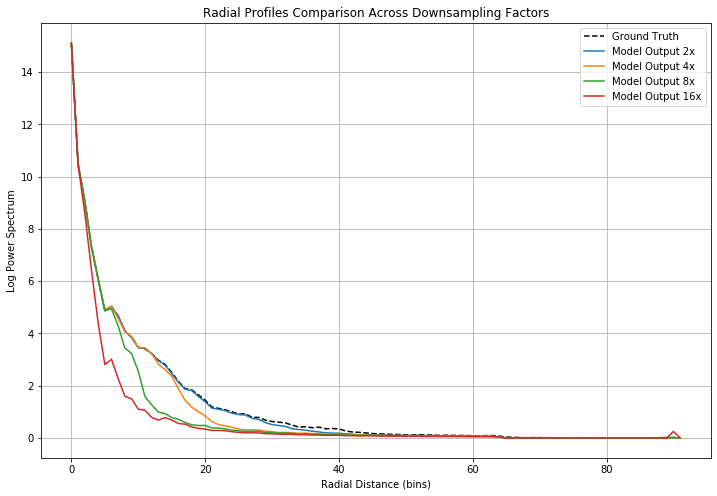

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_radial_profile(file_path):
    """Load the radial profile from a text file."""
    return np.loadtxt(file_path)

def plot_radial_profiles_from_folders(folder_paths, downsampling_factors, ground_truth_folder, output_path):
    """
    Plot radial profiles for different downsampling factors and a common ground truth.
    
    Parameters:
    - folder_paths: List of directories containing radial profile text files for different downsampling factors.
    - downsampling_factors: List of downsampling factors corresponding to each folder.
    - ground_truth_folder: Directory containing the radial profile text file for the ground truth.
    - output_path: Path where the plot will be saved.
    """
    plt.figure(figsize=(12, 8))
    
    # Load the ground truth radial profile
    gt_profile_path = os.path.join(ground_truth_folder, 'radial_profile_gt_2.txt')
    if os.path.exists(gt_profile_path):
        radial_profile_gt = load_radial_profile(gt_profile_path)
        plt.plot(np.arange(len(radial_profile_gt)), radial_profile_gt, label='Ground Truth', linestyle='--', color='black')
    else:
        raise FileNotFoundError(f"Ground truth file not found: {gt_profile_path}")

    # Load and plot radial profiles for model outputs
    for folder_path, factor in zip(folder_paths, downsampling_factors):
        model_profile_path = os.path.join(folder_path, 'radial_profile_model_2.txt')
        if os.path.exists(model_profile_path):
            radial_profile_model = load_radial_profile(model_profile_path)
            plt.plot(np.arange(len(radial_profile_model)), radial_profile_model, label=f'Model Output {factor}x')

    # Set plot labels and title
    plt.xlabel('Radial Distance (bins)')
    plt.ylabel('Log Power Spectrum')
    plt.title('Radial Profiles Comparison Across Downsampling Factors')
    plt.legend()
    plt.grid(True)
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()

folder_paths = [
    'radial_power_spectra/srflow/2x/',
    'radial_power_spectra/srflow/4x/',
    'radial_power_spectra/srflow/8x/',
    'radial_power_spectra/srflow/16x/'
]

downsampling_factors = ['2', '4', '8', '16']
ground_truth_folder = 'radial_power_spectra/srflow/2x/'
output_path = 'radial_power_spectra/radial_profiles_comparison.png'

plot_radial_profiles_from_folders(folder_paths, downsampling_factors, ground_truth_folder, output_path)


In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_radial_profile(file_path):
    """Load the radial profile from a text file."""
    return np.loadtxt(file_path)

def plot_comparison_radial_profiles(cnf_folders, gan_folders, downsampling_factors, ground_truth_folder, output_path):
    """
    Plot and compare radial profiles for CNF and GAN models across different downsampling factors.
    
    Parameters:
    - cnf_folders: List of directories containing radial profile text files for CNF models.
    - gan_folders: List of directories containing radial profile text files for GAN models.
    - downsampling_factors: List of downsampling factors corresponding to each folder.
    - ground_truth_folder: Directory containing the radial profile text file for the ground truth.
    - output_path: Path where the plot will be saved.
    """
    plt.figure(figsize=(14, 10))
    
    # Load and plot the ground truth radial profile
    gt_profile_path = os.path.join(ground_truth_folder, 'radial_profile_gt.txt')
    if os.path.exists(gt_profile_path):
        radial_profile_gt = load_radial_profile(gt_profile_path)
        plt.plot(np.arange(len(radial_profile_gt)), radial_profile_gt, label='Ground Truth', linestyle='--', color='black')
    else:
        raise FileNotFoundError(f"Ground truth file not found: {gt_profile_path}")

    # Load and plot radial profiles for CNF models
    for folder_path, factor in zip(cnf_folders, downsampling_factors):
        model_profile_path = os.path.join(folder_path, 'radial_profile_model.txt')
        if os.path.exists(model_profile_path):
            radial_profile_cnf = load_radial_profile(model_profile_path)
            plt.plot(np.arange(len(radial_profile_cnf)), radial_profile_cnf, label=f'CNF Output {factor}x')

    # Load and plot radial profiles for GAN models
    for folder_path, factor in zip(gan_folders, downsampling_factors):
        model_profile_path = os.path.join(folder_path, 'radial_profile_model.txt')
        if os.path.exists(model_profile_path):
            radial_profile_gan = load_radial_profile(model_profile_path)
            plt.plot(np.arange(len(radial_profile_gan)), radial_profile_gan, label=f'GAN Output {factor}x', linestyle='--')

    # Set plot labels and title
    plt.xlabel('Radial Distance (bins)')
    plt.ylabel('Log Power Spectrum')
    plt.title('Comparison of Radial Profiles: CNF vs. GAN')
    plt.legend()
    plt.grid(True)
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()

# Example usage
cnf_folders = [
    'path/to/cnf_2x_folder',
    'path/to/cnf_4x_folder',
    'path/to/cnf_8x_folder',
    'path/to/cnf_16x_folder'
]

gan_folders = [
    'path/to/gan_2x_folder',
    'path/to/gan_4x_folder',
    'path/to/gan_8x_folder',
    'path/to/gan_16x_folder'
]

downsampling_factors = ['2', '4', '8', '16']
ground_truth_folder = 'path/to/ground_truth_folder'
output_path = 'path/to/comparison_radial_profiles.png'

plot_comparison_radial_profiles(cnf_folders, gan_folders, downsampling_factors, ground_truth_folder, output_path)


FileNotFoundError: Ground truth file not found: path/to/ground_truth_folder/radial_profile_gt.txt

<Figure size 1008x720 with 0 Axes>